# Introduction

This notebook contains my implementation of the [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434) paper. I start off by going through the theory of the paper and then implementing the main ideas as best as I can within my resource constrained environment.

# Theory

**Contributions**

The main contributions of this paper are as follows:

1. The introduction of the DCGAN class of Convolutional GANs.
2. Unsupervised representation learning by leveraging the disciminator weights.
3. Visualisation of filters learned by the GAN and show that specific filters learn to draw specific objects.
4. The latent variable has an vector arithmetic property that allows for generation of samples with semantic qualities.

**Significance**

This paper advances the GAN architecture to yield better looking results while highlighting the potential applications of the GAN.

***Note*** This paper is largely experimental with little to no theory.

**Main Ideas**

The authors peformed a vast amount of experimentation to determine architectural constraints that allowed for training higher resolution images and deeper generative models.

Firstly, they determined that an all convolutional net, replacing pooling functions with strided/fractional-strided convolutions in the Disciminator/Generator resulted in the best performance.

Second, By eliminating Fully connected layers on top of convolutions they were able to get the best performance. But using a Fully connected layer at the start of the Generator network was okay. In the disciminator, the last convoluational layer is flattened and fed into a single sigmoid layer.

Third, Batch Normalisation resulted in the best performance by helping training. They said that this proved critical to stop mode collapse. Additionally, applying BatchNorm to all layers resulted in sample oscillation and model instability - avoided by not applying BatchNorm to the generator output layer and disciminator input layer.

***Note***

From my experiments, applying Batch Normalisation in any of the Disciminator layers results in non-convergence.

Fourth, use ReLU activation on all generator layers (except last) and leaky ReLU on all disciminator layers (except last).

These are summarised as follows:

- Replace any pooling layers with Strided/Fractional-Strided Convolutions in the Discimnator/Generator
- Use BatchNorm in both Generator (except final layer) and Discriminator (except first layer). **My experiments showed that using BatchNorm in Disciminator resulted in non-convergence**
- Remove fully-connected layers after convolutional layers (Disciminator: final layer is Sigmoid layer, Generator: first layer can be FFNN from latent space).
- Use ReLU activation in Generator.
- Use LeakyReLU activation in Disciminator.


# Implementation

**Disclamer**

The LSUN bedroom dataset is too large, so I will instead use the LSUN conference room dataset.

## Imports and Installations

In [1]:
!pip install clu
!pip install orbax

In [2]:
# Don't preallocate VRAM
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [3]:
# Mount Drive
from google.colab import drive
drive.mount("/content/drive")

# data loading
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pathlib

# deep learning
import jax
import jax.numpy as jnp
import flax
import flax.linen as nn
import optax
from clu import metrics
from functools import partial

# plotting
import matplotlib.pyplot as plt

# timing
from time import perf_counter

# Checkpointing
import orbax
from flax.training import orbax_utils

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Hyperparameters

In [4]:
tf.random.set_seed(42)

k = 1
batch_size = 128
latent_dim = 100
EPOCHS = 40
lr = 2e-4

ng = 48
nd = 48

weight_init = nn.initializers.normal(0.02)
scale_init = lambda key, shape, dtype: nn.initializers.constant(1.0)(key, shape, dtype) + nn.initializers.normal(0.02)(key, shape, dtype)
bias_init = nn.initializers.constant(0.0)

latent_dist = lambda key, shape, dtype: jax.random.normal(key, shape, dtype)

## Data Loading

In [5]:
def get_celeb(batch_size, return_sample=True):
  def neg1_1_normalise(data):
    return (tf.cast(data, dtype=tf.float32) - 127.5) / 127.5

  path = "file:/content/drive/MyDrive/BlogPosts/img_align_celeba.zip"

  data_dir = tf.keras.utils.get_file(origin=path, extract=True)
  data_dir = pathlib.Path(data_dir).with_suffix("")

  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=42,
    labels=None,
    batch_size=None,
    image_size=(48, 48),
    crop_to_aspect_ratio=True
  )

  train_ds = train_ds.map(neg1_1_normalise, num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(1000).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

  if return_sample == True:
    for sample_data in train_ds.as_numpy_iterator():
      print("Sample data:", sample_data.shape)
      plt.figure(figsize=(2,2))
      plt.imshow((sample_data[0]+1)/2)
      return train_ds, sample_data
  return train_ds

Found 202599 files belonging to 1 classes.
Sample data: (128, 48, 48, 3)
tf.Tensor(1582, shape=(), dtype=int64)


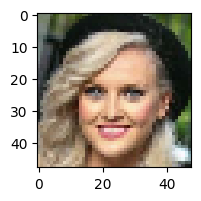

In [6]:
train_ds, sample_data = get_celeb(batch_size)
print(train_ds.cardinality())

## TrainState and Metrics

In [7]:
from flax.training import train_state

@flax.struct.dataclass
class Metrics(metrics.Collection):
  loss: metrics.Average.from_output("loss")

class TrainState(train_state.TrainState):
  rng: jax.Array
  metrics: Metrics = Metrics.empty()
  batch_stats: flax.core.FrozenDict = None

## Create and Initialise State

In [8]:
def create_state_and_initialise_model(G, D, sample_data, latent_dim, random_key):
  keys = jax.random.split(random_key, 4)
  sample_latent = jnp.zeros((batch_size, latent_dim))

  g = G()
  d = D()

  g_vars = g.init(keys[0], sample_latent, train=False)
  d_vars = d.init(keys[1], sample_data, train=False)


  print(g.tabulate(keys[0], sample_latent, train=False))
  print(d.tabulate(keys[1], sample_data, train=False))

  g_state = TrainState.create(
      apply_fn=g.apply,
      params=g_vars["params"],
      tx=optax.adam(lr, b1=0.5),
      rng=keys[2],
      batch_stats=g_vars["batch_stats"]
  )

  d_state = TrainState.create(
      apply_fn=d.apply,
      params=d_vars["params"],
      tx=optax.adam(lr, b1=0.5),
      rng=keys[3],
      batch_stats=None
  )

  print("G output shape:", g_state.apply_fn({"params": g_state.params, "batch_stats": g_state.batch_stats}, sample_latent, train=False).shape)
  print("D output shape:", d_state.apply_fn({"params": d_state.params}, sample_data, train=False).shape)

  return g_state, d_state, g, d

## Model Definition

In [9]:
class G(nn.Module):
  @nn.compact
  def __call__(self, z, train):
    z = jnp.broadcast_to(z, [9, z.shape[0], 100]).reshape([z.shape[0], 3, 3, 100])

    z = nn.ConvTranspose(features=ng * 8, kernel_size=(4,4), strides=(1, 1), kernel_init=weight_init, use_bias=False)(z)
    z = nn.BatchNorm(momentum=0.9, bias_init=bias_init, scale_init=scale_init)(z, use_running_average=not train)
    z = nn.relu(z)
    z = nn.Dropout(0.0, deterministic=not train)(z)

    z = nn.ConvTranspose(features=ng * 4, kernel_size=(4,4), strides=(2,2), kernel_init=weight_init, use_bias=False)(z)
    z = nn.BatchNorm(momentum=0.9, bias_init=bias_init, scale_init=scale_init)(z, use_running_average=not train)
    z = nn.relu(z)
    z = nn.Dropout(0.0, deterministic=not train)(z)

    z = nn.ConvTranspose(features=ng * 2, kernel_size=(4,4), strides=(2,2), kernel_init=weight_init, use_bias=False)(z)
    z = nn.BatchNorm(momentum=0.9, bias_init=bias_init, scale_init=scale_init)(z, use_running_average=not train)
    z = nn.relu(z)
    z = nn.Dropout(0.0, deterministic=not train)(z)

    z = nn.ConvTranspose(features=ng * 1, kernel_size=(4,4), strides=(2,2), kernel_init=weight_init, use_bias=False)(z)
    z = nn.BatchNorm(momentum=0.9, bias_init=bias_init, scale_init=scale_init)(z, use_running_average=not train)
    z = nn.relu(z)
    z = nn.Dropout(0.0, deterministic=not train)(z)

    z = nn.ConvTranspose(features=3, kernel_size=(4, 4), strides=(2, 2), kernel_init=weight_init, use_bias=False)(z)
    z = nn.tanh(z)
    return z

class D(nn.Module):
  @nn.compact
  def __call__(self, x, train):
    x = nn.Conv(features=nd * 1, kernel_size=(4,4), strides=(2,2), kernel_init=weight_init)(x)
    x = nn.leaky_relu(x, 0.2)
    x = nn.Dropout(0.0, deterministic=not train)(x)

    x = nn.Conv(features=nd * 2, kernel_size=(4,4), strides=(2,2), kernel_init=weight_init, use_bias=False)(x)
    x = nn.LayerNorm()(x)
    x = nn.leaky_relu(x, 0.2)
    x = nn.Dropout(0.0, deterministic=not train)(x)

    x = nn.Conv(features=nd * 4, kernel_size=(4,4), strides=(2,2), kernel_init=weight_init, use_bias=False)(x)
    x = nn.LayerNorm()(x)
    x = nn.leaky_relu(x, 0.2)
    x = nn.Dropout(0.0, deterministic=not train)(x)

    x = nn.Conv(features=nd * 8, kernel_size=(4,4), strides=(2, 2), kernel_init=weight_init, use_bias=False)(x)
    x = nn.LayerNorm()(x)
    x = nn.leaky_relu(x, 0.2)
    x = nn.Dropout(0.0, deterministic=not train)(x)

    x = x.reshape([x.shape[0], -1])
    x = nn.Dense(1, kernel_init=weight_init, use_bias=False)(x)
    return x

## Disciminator Train Step

In [10]:
@jax.jit
def d_train_step(g_state, d_state, data):
  ones = jnp.ones((batch_size, 1))
  zeros = jnp.zeros((batch_size, 1))
  latent_key, d_dropout_key_1, d_dropout_key_2 = jax.random.split(jax.random.fold_in(d_state.rng, d_state.step), 3)
  z = latent_dist(latent_key, (batch_size, latent_dim), data.dtype)
  def loss(params):
    tru_logits = d_state.apply_fn({"params": params}, data, train=True, rngs={"dropout": d_dropout_key_1})
    tru_loss = optax.sigmoid_binary_cross_entropy(logits=tru_logits, labels=ones)

    gen_x = g_state.apply_fn({"params": g_state.params, "batch_stats": g_state.batch_stats}, z, train=False)
    gen_logits = d_state.apply_fn({"params": params}, gen_x, train=True, rngs={"dropout": d_dropout_key_2})
    gen_loss = optax.sigmoid_binary_cross_entropy(logits=gen_logits, labels=zeros)

    return (tru_loss + gen_loss).mean() / 2

  grad_fn = jax.value_and_grad(loss)

  d_loss, grads = grad_fn(d_state.params)

  metrics = d_state.metrics.single_from_model_output(loss=d_loss)
  metrics = d_state.metrics.merge(metrics)

  d_state = d_state.apply_gradients(grads=grads, metrics=metrics)
  return d_state

## Generator Train Step

In [11]:
@jax.jit
def g_train_step(g_state, d_state, data):
  ones = jnp.ones((batch_size, 1))
  latent_key, g_dropout_key = jax.random.split(jax.random.fold_in(g_state.rng, g_state.step), 2)
  z = latent_dist(latent_key, (batch_size, latent_dim), data.dtype)
  def loss(params):
    gen_x, updates = g_state.apply_fn({"params": params, "batch_stats": g_state.batch_stats}, z, train=True, rngs={"dropout": g_dropout_key}, mutable=["batch_stats"])
    logits = d_state.apply_fn({"params": d_state.params}, gen_x, train=False)
    loss = optax.sigmoid_binary_cross_entropy(logits=logits, labels=ones).mean()
    return loss, updates

  grad_fn = jax.value_and_grad(loss, has_aux=True)

  (g_loss, updates), grads = grad_fn(g_state.params)

  metrics = g_state.metrics.single_from_model_output(loss=g_loss)
  metrics = g_state.metrics.merge(metrics)

  g_state = g_state.apply_gradients(grads=grads, metrics=metrics, batch_stats=updates["batch_stats"])
  return g_state

## Helpers

In [12]:
def update_metrics(g_state, d_state, metrics_history):
  for k,v in g_state.metrics.compute().items():
    metrics_history[f"g_train_{k}"].append(v)
  for k,v in d_state.metrics.compute().items():
    metrics_history[f"d_train_{k}"].append(v)
  d_state = d_state.replace(metrics=d_state.metrics.empty())
  g_state = g_state.replace(metrics=g_state.metrics.empty())
  return g_state, d_state, metrics_history

In [99]:
def neg1_1_to_0_1(image):
  return (image + 1.0) / 2.0

def plot_samples(n=None, z=None):
  if z == None:
    z = latent_dist(jax.random.PRNGKey(453453), shape=(10, latent_dim), dtype=jnp.float32)
  n = len(z)

  gen_x = g_state.apply_fn({"params": g_state.params, "batch_stats": g_state.batch_stats}, z, train=False)
  gen_x = neg1_1_to_0_1(gen_x)

  fig, axs = plt.subplots(nrows=1, ncols=n, figsize=(10, n*10))
  for i in range(n):
    axs[i].imshow(gen_x[i], interpolation="nearest")
  plt.axis("off")
  plt.tight_layout()
  plt.show()

## Training

In [14]:
g_state, d_state, g, d = create_state_and_initialise_model(G, D, sample_data, latent_dim, jax.random.PRNGKey(0))


                                             G Summary                                              
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path           ┃ module        ┃ inputs        ┃ outputs        ┃ batch_stats   ┃ params         ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│                │ G             │ -             │ float32[128,4… │               │                │
│                │               │ float32[128,… │                │               │                │
│                │               │ - train:      │                │               │                │
│                │               │ False         │                │               │                │
├────────────────┼───────────────┼───────────────┼────────────────┼───────────────┼────────────────┤
│ ConvTranspose… │ ConvTranspose │ float32[128,… │ float32[128,3… │               │ kernel

In [15]:
metrics_history = {
    "g_train_loss" : [],
    "d_train_loss" : [],
}

In [16]:
# Setup Checkpointing

orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=5, create=True)
checkpoint_manager = orbax.checkpoint.CheckpointManager(
  "/content/drive/MyDrive/BlogPosts/Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks/Checkpoints",
  orbax_checkpointer,
  options
)

ckpt = {"generator": g_state, "discriminator": d_state}
save_args = orbax_utils.save_args_from_target(ckpt)
checkpoint_manager.save(0, ckpt, save_kwargs={"save_args": save_args})

True

Epoch 1|d step 791, g step 791| Time: 113.94276496800012s| g_loss: 4.801015377044678| d_loss: 0.19795283675193787.


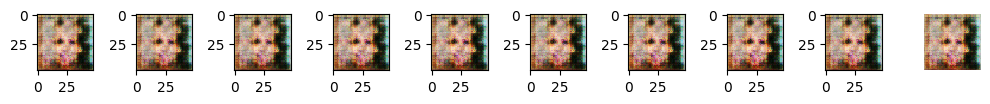

Epoch 2|d step 1582, g step 1582| Time: 61.05639540900029s| g_loss: 2.5206220149993896| d_loss: 0.16913512349128723.


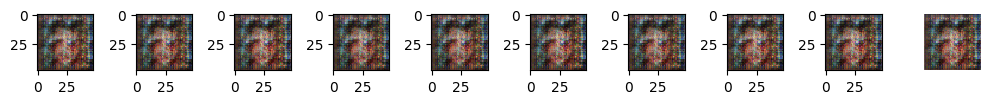

Epoch 3|d step 2373, g step 2373| Time: 81.91192354699979s| g_loss: 3.0879101753234863| d_loss: 0.19729328155517578.


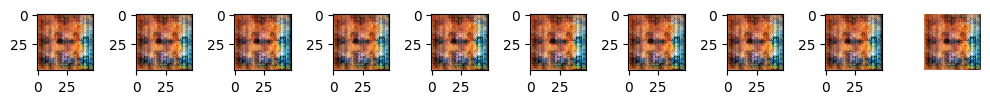

Epoch 4|d step 3164, g step 3164| Time: 61.508962729999894s| g_loss: 2.562978506088257| d_loss: 0.17136895656585693.


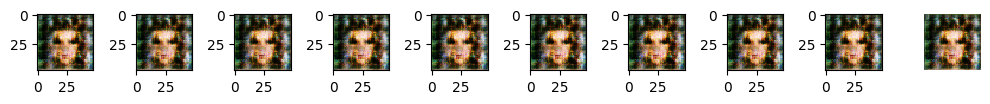

Epoch 5|d step 3955, g step 3955| Time: 60.33628416600004s| g_loss: 2.9514575004577637| d_loss: 0.18616648018360138.


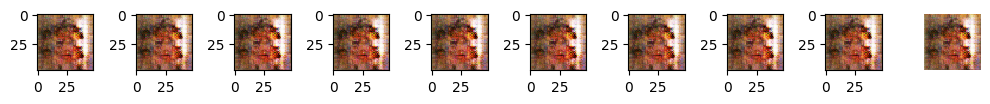

Epoch 6|d step 4746, g step 4746| Time: 81.90721814300014s| g_loss: 2.688281297683716| d_loss: 0.16007515788078308.


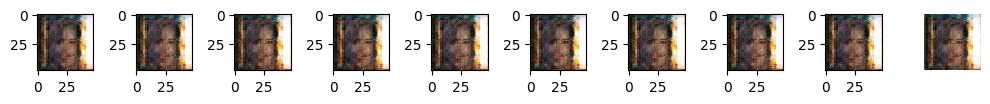

Epoch 7|d step 5537, g step 5537| Time: 61.46303520099991s| g_loss: 3.1812684535980225| d_loss: 0.17906460165977478.


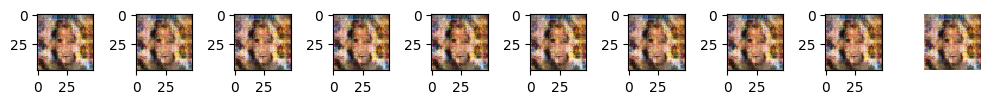

Epoch 8|d step 6328, g step 6328| Time: 60.31353933599985s| g_loss: 2.7919981479644775| d_loss: 0.14833705127239227.


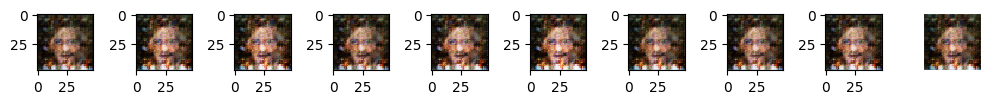

Epoch 9|d step 7119, g step 7119| Time: 60.58757673199989s| g_loss: 3.4696621894836426| d_loss: 0.22852027416229248.


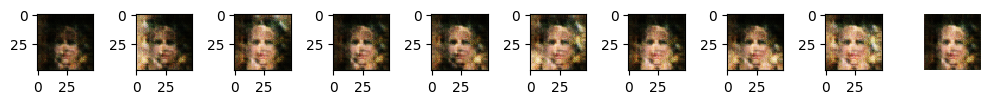

Epoch 10|d step 7910, g step 7910| Time: 81.91125218799971s| g_loss: 4.155856132507324| d_loss: 0.22222468256950378.


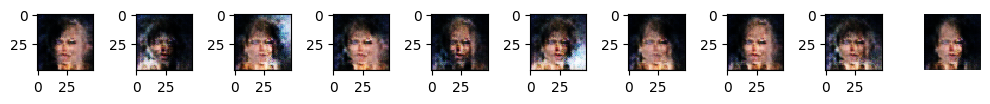

Epoch 11|d step 8701, g step 8701| Time: 61.643297695s| g_loss: 4.036759376525879| d_loss: 0.2082921415567398.


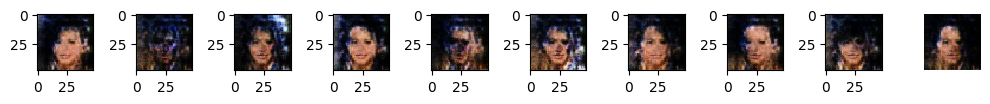

Epoch 12|d step 9492, g step 9492| Time: 81.909124884s| g_loss: 3.9835147857666016| d_loss: 0.20613405108451843.


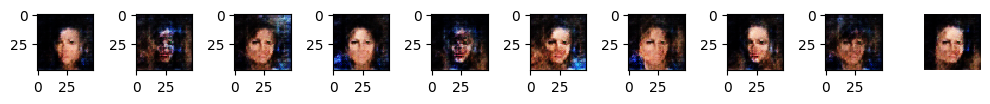

Epoch 13|d step 10283, g step 10283| Time: 61.63937234500008s| g_loss: 4.232970714569092| d_loss: 0.16058985888957977.


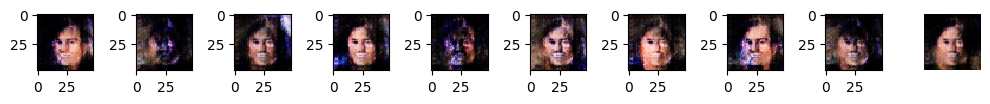

Epoch 14|d step 11074, g step 11074| Time: 60.428589035000186s| g_loss: 4.385213851928711| d_loss: 0.1516515463590622.


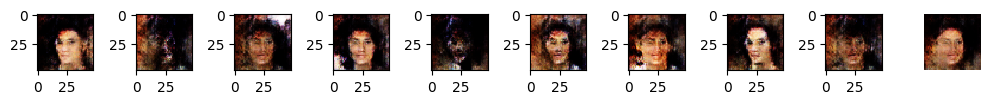

Epoch 15|d step 11865, g step 11865| Time: 81.90992605600013s| g_loss: 4.4697489738464355| d_loss: 0.13947123289108276.


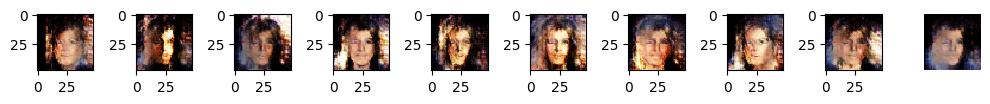

Epoch 16|d step 12656, g step 12656| Time: 61.75557055299987s| g_loss: 4.674645900726318| d_loss: 0.12740598618984222.


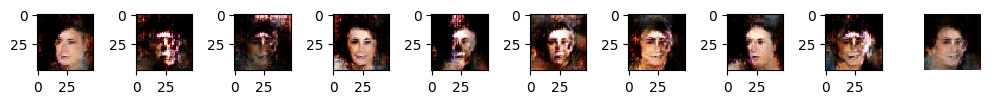

Epoch 17|d step 13447, g step 13447| Time: 81.91146740899967s| g_loss: 4.123017311096191| d_loss: 0.1631508767604828.


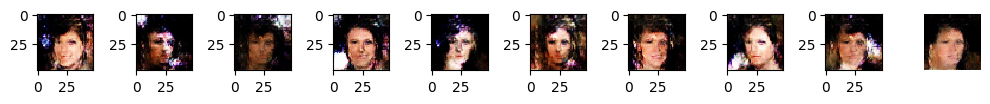

Epoch 18|d step 14238, g step 14238| Time: 61.56829977699999s| g_loss: 4.465905666351318| d_loss: 0.12532925605773926.


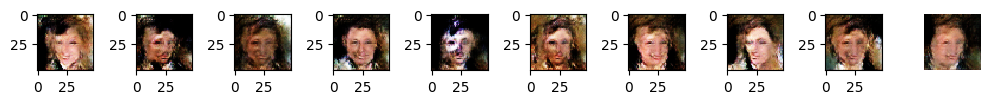

Epoch 19|d step 15029, g step 15029| Time: 60.68386107000015s| g_loss: 4.359222412109375| d_loss: 0.13972529768943787.


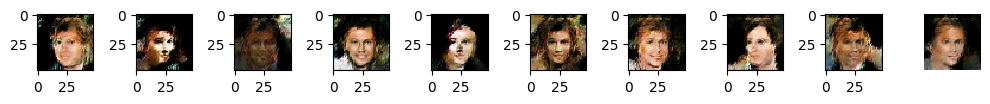

Epoch 20|d step 15820, g step 15820| Time: 81.90651033799986s| g_loss: 3.97660493850708| d_loss: 0.1676403135061264.


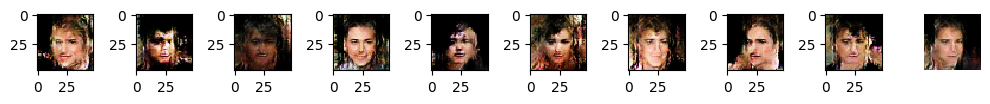

Epoch 21|d step 16611, g step 16611| Time: 61.77372341800037s| g_loss: 4.1725335121154785| d_loss: 0.14275440573692322.


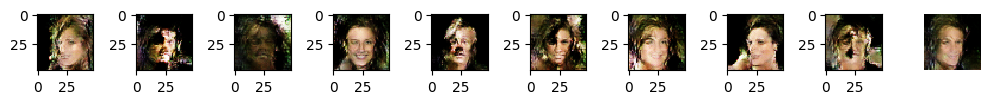

Epoch 22|d step 17402, g step 17402| Time: 81.90680541700021s| g_loss: 3.834125518798828| d_loss: 0.16776983439922333.


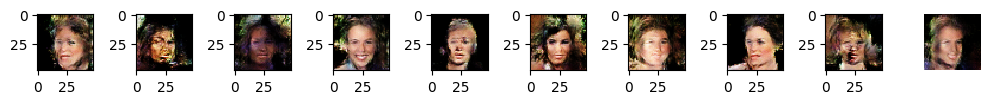

Epoch 23|d step 18193, g step 18193| Time: 61.71216579200018s| g_loss: 3.692277669906616| d_loss: 0.16813382506370544.


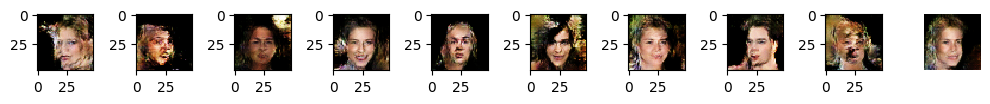

Epoch 24|d step 18984, g step 18984| Time: 60.765625051999905s| g_loss: 3.7022407054901123| d_loss: 0.16794322431087494.


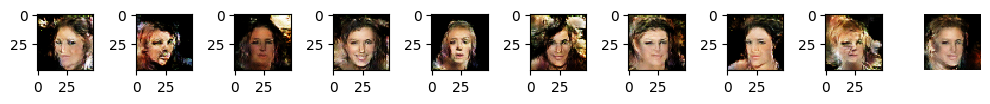

Epoch 25|d step 19775, g step 19775| Time: 81.9099690349999s| g_loss: 3.377437114715576| d_loss: 0.2069115936756134.


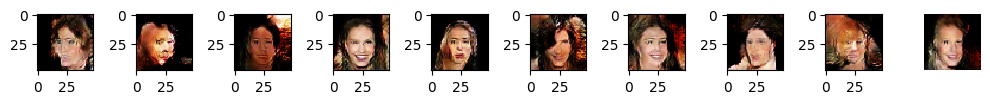

Epoch 26|d step 20566, g step 20566| Time: 61.69809065800018s| g_loss: 3.4012503623962402| d_loss: 0.19418181478977203.


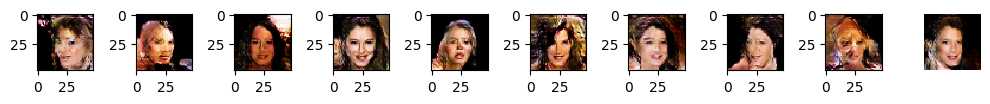

Epoch 27|d step 21357, g step 21357| Time: 81.91793789800022s| g_loss: 3.4810373783111572| d_loss: 0.17721962928771973.


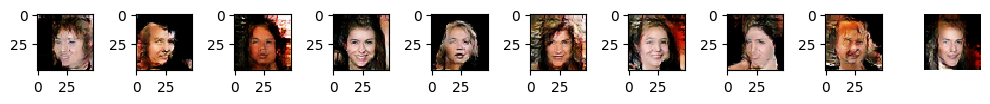

Epoch 28|d step 22148, g step 22148| Time: 61.65990220200001s| g_loss: 3.277130365371704| d_loss: 0.2054227739572525.


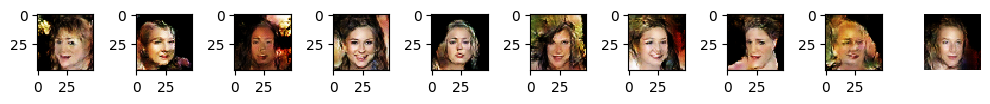

Epoch 29|d step 22939, g step 22939| Time: 60.49291743599997s| g_loss: 3.3105392456054688| d_loss: 0.19643482565879822.


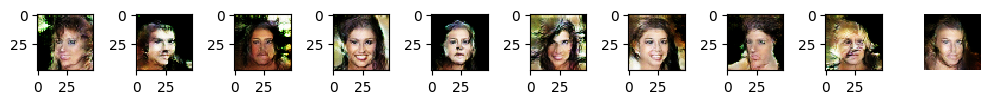

Epoch 30|d step 23730, g step 23730| Time: 81.91014649399995s| g_loss: 3.475013494491577| d_loss: 0.17344976961612701.


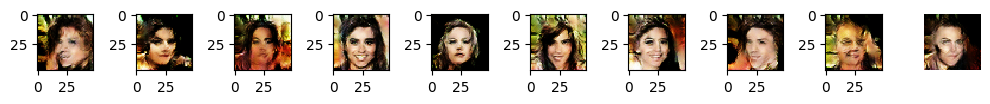

Epoch 31|d step 24521, g step 24521| Time: 61.695104250999975s| g_loss: 3.3669679164886475| d_loss: 0.19702596962451935.


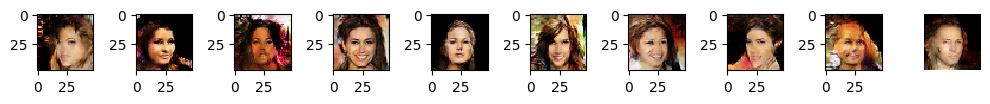

Epoch 32|d step 25312, g step 25312| Time: 60.55525301599937s| g_loss: 3.4582808017730713| d_loss: 0.1758616417646408.


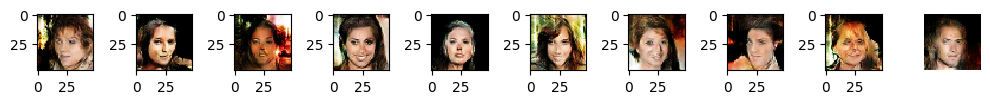

Epoch 33|d step 26103, g step 26103| Time: 81.91250206899986s| g_loss: 3.3672733306884766| d_loss: 0.1864510327577591.


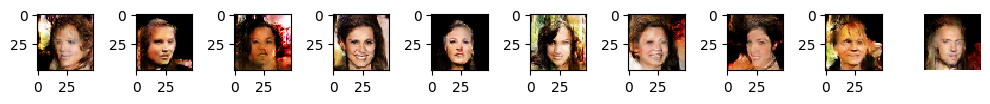

Epoch 34|d step 26894, g step 26894| Time: 61.7321434129999s| g_loss: 3.2963578701019287| d_loss: 0.19691699743270874.


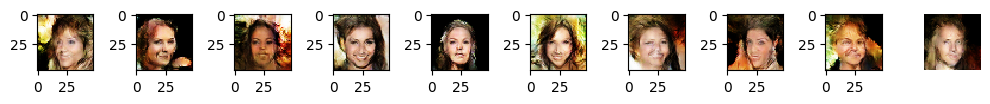

Epoch 35|d step 27685, g step 27685| Time: 60.551560800000516s| g_loss: 3.466005325317383| d_loss: 0.1700809895992279.


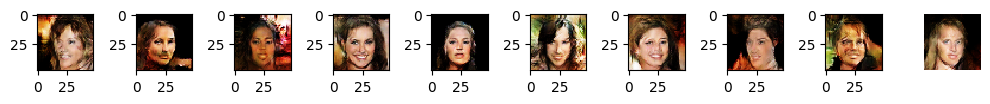

Epoch 36|d step 28476, g step 28476| Time: 81.91031718000067s| g_loss: 3.475193738937378| d_loss: 0.17266254127025604.


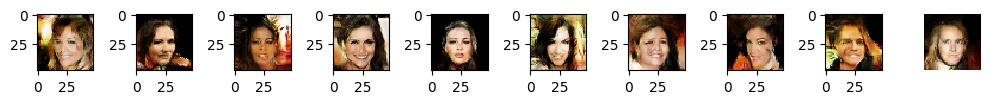

Epoch 37|d step 29267, g step 29267| Time: 61.61248681500001s| g_loss: 3.157000780105591| d_loss: 0.21380554139614105.


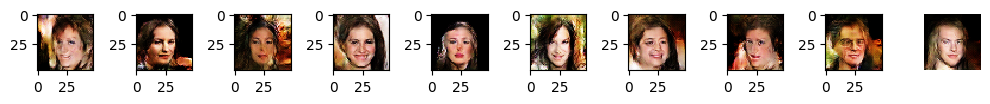

Epoch 38|d step 30058, g step 30058| Time: 60.4725650929995s| g_loss: 3.354300022125244| d_loss: 0.18461735546588898.


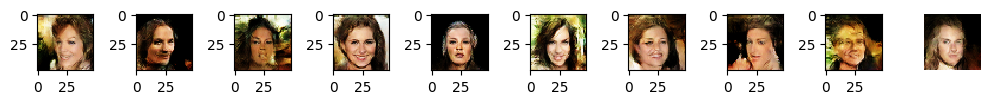

Epoch 39|d step 30849, g step 30849| Time: 60.642206988s| g_loss: 3.4341750144958496| d_loss: 0.17353954911231995.


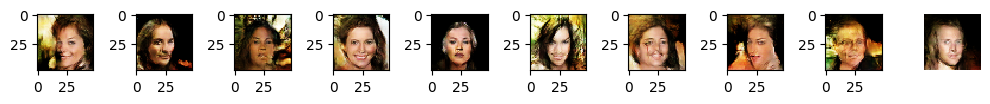

Epoch 40|d step 31640, g step 31640| Time: 60.59621848799998s| g_loss: 3.170978546142578| d_loss: 0.22701440751552582.


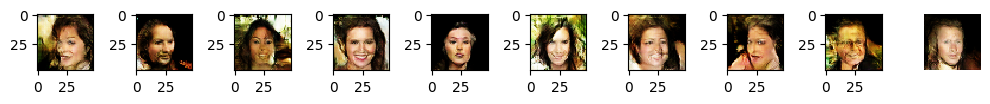

In [17]:
# batch - None

i = 0
plt.ion()

for epoch in range(1, EPOCHS + 1):
  start = perf_counter()
  for batch in train_ds.as_numpy_iterator():
    if i < k:
      d_state = d_train_step(g_state, d_state, batch)
      i += 1
    else:
      g_state = g_train_step(g_state, d_state, batch)
      i = 0

  g_state, d_state, metrics_history = update_metrics(g_state, d_state, metrics_history)

  g_loss = metrics_history["g_train_loss"][-1]
  d_loss = metrics_history["d_train_loss"][-1]

  print(f"Epoch {epoch}|d step {d_state.step}, g step {g_state.step}| Time: {perf_counter() - start}s| g_loss: {g_loss}| d_loss: {d_loss}.")
  plot_samples()

  ckpt = {"generator": g_state, "discriminator": d_state}
  save_args = orbax_utils.save_args_from_target(ckpt)
  checkpoint_manager.save(epoch, ckpt, save_kwargs={"save_args": save_args})